In [1]:
!pip install gudhi
!pip install POT
!pip install eagerpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 17.2 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import random
import copy
import torchvision
import torch
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from torchvision import transforms as T
from keras.datasets import mnist
from torch import nn
from gudhi.wasserstein import wasserstein_distance
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
np.random.seed(12345)
random.seed(12345)
torch.manual_seed(12345)

In [4]:
# Вспомогательная функция для отрисовки изображений
def plot(img):
    plt.figure()
    plt.imshow(img.detach().numpy().reshape(28, 28), cmap='gray')

## Задание параметров

In [5]:
beta = 0.75
batch_size_value = 32
n_repeats = 3
n_epochs = 50
lr = 1e-3
noise = 'topological'
# noise = 'salt&pepper'
# noise = 'gaussian'

## Задаём модели

In [6]:
class Autoencoder(nn.Module):

    def __init__(self, d_input, d_hidden):
        super().__init__()
        self.autoencoder = nn.Sequential(
            MLP(d_input, d_hidden * 4, d_hidden),
            MLP(d_hidden, d_hidden * 4, d_input)
        )

    def forward(self, X):
        return self.autoencoder(X)


class MLP(nn.Module):

    def __init__(self, in_channels, h_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.GELU(),
            nn.Linear(h_channels, out_channels)
        )

    def forward(self, X):
        return self.mlp(X)

## Подготовка данных

In [7]:
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: torch.flatten(x))
])

In [8]:
# Загружаем датасет
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

11490434/11490434 [==============================] - 1s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


In [9]:
# Задаём вид шума
def add_noise(img, noise_type):
    if noise_type == 'topological':
        row, col = 28, 28
        coef = 0.2
        img = img.astype(np.float32)
        row, col = img.shape
        num_of_lines = int((row + col) * coef)
        for i in range(num_of_lines):
            x1 = x2 = 0
            while (x1 == x2):
                x1, y1 = random.randint(0, col - 1), random.randint(0, row - 1)
                x2, y2 = random.randint(0, col - 1), random.randint(0, row - 1)
            k = (y2 - y1) / (x2 - x1)
            b = y1 - k * x1
            color = random.randint(0, 255)
            for x in range(min(x1, x2) + 1, max(x1, x2) - 1):
                y = round(k * x + b)
                img[y][x] = color
        return img
    elif noise_type == 'salt&pepper':
        coef = 0.2
        row, col = img.shape
        n = (np.random.normal(loc=0,
                              scale=100 * coef,
                              size=(row, col)))
        return n.astype(int) + img
    elif noise_type == 'gaussian':
        coef = 0.2
        image = copy.deepcopy(img)
        row, col = image.shape

        number_of_pixels = int(coef * row * col) // 2
        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 255

        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 0

        return image

In [10]:
# Создаём обучающую выборку
noise_ct = 0
noise_id = 0
traindata = np.zeros((10000, 28, 28))

for idx in tqdm(range(10000)):

    if noise_ct < (10000):
        noise_ct += 1
        traindata[idx] = add_noise(xtrain[idx], noise_type=noise)

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

noise_ct = 0
noise_id = 0
testdata = np.zeros((500, 28, 28))

for idx in tqdm(range(500)):

    if noise_ct < (len(xtest) / 2):
        noise_ct += 1
        x = add_noise(xtest[idx], noise_type=noise)
        testdata[idx] = x

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

100%|██████████| 10000/10000 [00:02<00:00, 4955.25it/s]



topological noise addition completed to images


100%|██████████| 500/500 [00:00<00:00, 4831.01it/s]


topological noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

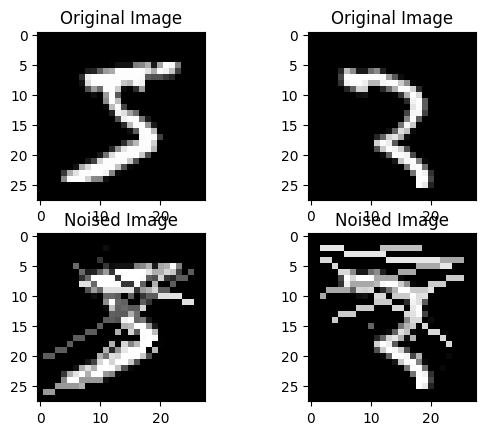

In [11]:
# Немного визуализации

f, axes = plt.subplots(2, 2)

# showing images with gaussian noise
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

# showing images with speckle noise
axes[0, 1].imshow(xtrain[500], cmap='gray')
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[500], cmap="gray")
axes[1, 1].set_title("Noised Image")

In [12]:
# Создаём класс для датасета

class noisedDataset(torch.utils.data.Dataset):

    def __init__(self, datasetnoised, datasetclean, labels, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]
        y = self.labels[idx]

        if self.transform != None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return (xNoise, xClean, y)

In [13]:
# Создаём сеты для DataLoader'а
tsfms = T.Compose([
    T.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [14]:
# Создаём сам DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [15]:
# Используем cuda по возможности
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"

In [16]:
# Берём несколько изображений для проверки на корректность работы 
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [17]:
dirty.shape

torch.Size([32, 784])

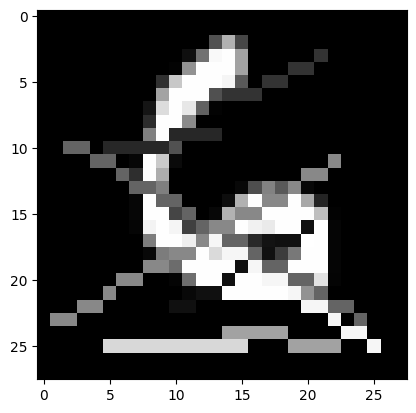

In [18]:
plot(dirty[2])

In [19]:
# Проверка инициализации модели
model = Autoencoder(28 * 28, 32)

# Берём один батч
X, y = dirty, clean

# Применяем модель
Y = model(X)
X.shape, Y.shape

(torch.Size([32, 784]), torch.Size([32, 784]))

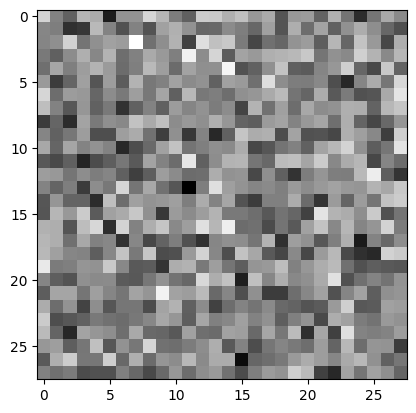

In [20]:
plot(Y[2])

## Задаём функции потерь

In [21]:
def diagram(image):
    # Получаем размер изображения
    h = int(np.sqrt(image.shape[0]))
    image_sq = image.reshape((h, h))

    # Создаём кубический комплекс
    cmplx = gd.CubicalComplex(dimensions=(h, h), top_dimensional_cells=image)

    # Получаем персистентные пары для кубической фильтрации
    cmplx.compute_persistence()
    critical_pairs = cmplx.cofaces_of_persistence_pairs()

    # Получаем номер пикселя в исходном изображении
    bpx0_essential = critical_pairs[1][0][0] // h, critical_pairs[1][0][0] % h

    # Получаем критические пиксели, соответствующие персистентным парам
    try:
        bpx0 = [[critical_pairs[0][0][i][0] // h, critical_pairs[0][0][i][0] % h] for i in
                range(len(critical_pairs[0][0]))]
        dpx0 = [[critical_pairs[0][0][i][1] // h, critical_pairs[0][0][i][1] % h] for i in
                range(len(critical_pairs[0][0]))]
    except IndexError:
        bpx0 = [[]]
        dpx0 = [[]]

    try:
        bpx1 = [[critical_pairs[0][1][i][0] // h, critical_pairs[0][1][i][0] % h] for i in
                range(len(critical_pairs[0][1]))]
        dpx1 = [[critical_pairs[0][1][i][1] // h, critical_pairs[0][1][i][1] % h] for i in
                range(len(critical_pairs[0][1]))]
    except IndexError:
        bpx1 = [[]]
        dpx1 = [[]]

    idx0, idx1 = np.stack([bpx0, dpx0]).T, np.stack([bpx1, dpx1]).T

    # Добавляем нулевой гомологический класс
    pd0_essential = torch.tensor([[image_sq[bpx0_essential], torch.max(image)]])

    # получаем диаграмму устойчивости через индексацию
    if (len(idx0) != 0):
        pd0 = image_sq[idx0]
        pd0 = torch.vstack([pd0, pd0_essential])
    else:
        pd0 = pd0_essential

    if (len(idx1) != 0):
        pd1 = image_sq[idx1]
    else:
        pd1 = torch.zeros((1, 2))

    return pd0, pd1

In [22]:
# Функция для сравнения диаграмм устойчивости
def compare(image1, image2):
    first_pd0, first_pd1 = diagram(image1)
    second_pd0, second_pd1 = diagram(image2)

    return wasserstein_distance(first_pd0, second_pd0, enable_autodiff=True) + \
        wasserstein_distance(first_pd1, second_pd1, enable_autodiff=True)


# Функция топологических потерь
def topo_loss(output, target):
    loss = torch.tensor(0.)
    for i in range(len(output)):
        loss += compare(output[i], target[i])
    return (loss / len(output))

In [23]:
# Проверка работы функции
X_pd0, X_pd1 = diagram(X[7])
Y_pd0, Y_pd1 = diagram(Y[7])
#X_pd0, Y_pd0

In [24]:
# Проверка подсчёта расстояния между диаграммами
wasserstein_distance(X_pd0, Y_pd0, enable_autodiff=True)

/opt/conda/lib/python3.10/site-packages/gudhi/wasserstein/wasserstein.py:282: UserWarning: enable_autodiff=True and keep_essential_parts=True are incompatible together.
                      keep_essential_parts is set to False: only points with finite coordinates are considered
                      in the following.
                      
  warnings.warn('''enable_autodiff=True and keep_essential_parts=True are incompatible together.


tensor(311.0061, grad_fn=<SumBackward0>)

## Checking

Проверка работоспособности функции и вычисления градиента

In [25]:
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [26]:
loss = topo_loss(dirty, clean)

In [27]:
loss.item()

2166.493408203125

In [28]:
loss.backward()

In [29]:
dirty.grad

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0156]])

## Train process

Обучение

In [30]:
%%time
batch_size = batch_size_value

history = np.zeros((n_repeats, n_epochs, 2))

mse_loss_fn = nn.MSELoss()
topo_loss_fn = topo_loss

for repeat_idx in range(n_repeats):

    # Инициализация DataLoader'а
    dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Инициализация модели
    model = Autoencoder(28 * 28, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("{:3} {:6} {:6}".format(repeat_idx + 1, "MSE", "Topo"))

    for epoch_idx in range(n_epochs):

        # Обучение
        model.train()

        mse_loss_epoch = []
        topo_loss_epoch = []

        for X, y, label in tqdm(dataloader_train):
            X = X.view(X.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            y = y.view(y.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            mse_loss_batch = mse_loss_fn(model(X), y)
            topo_loss_batch = topo_loss_fn(model(X), y)
            loss_batch = mse_loss_batch + beta * topo_loss_batch

            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

            mse_loss_epoch.append(mse_loss_batch.detach())
            topo_loss_epoch.append(topo_loss_batch.detach())

        mse_loss_mean = np.mean(mse_loss_epoch)
        topo_loss_mean = np.mean(topo_loss_epoch)

        history[repeat_idx, epoch_idx, 0] = mse_loss_mean
        history[repeat_idx, epoch_idx, 1] = topo_loss_mean

        print("{:3} {:.4f} {:.4f}".format(epoch_idx, mse_loss_mean, topo_loss_mean))
    torch.save(model.state_dict(), f"custom_model_{repeat_idx + 1}.pt")
    print("\r")

  1 MSE    Topo  


100%|██████████| 313/313 [02:26<00:00,  2.13it/s]


  0 4639.1406 1711.1162


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


  1 3676.1790 1549.5425


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


  2 3372.4038 1535.7512


100%|██████████| 313/313 [02:25<00:00,  2.16it/s]


  3 3226.5076 1533.9987


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


  4 3122.2173 1522.2939


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


  5 3033.9292 1520.1001


100%|██████████| 313/313 [02:20<00:00,  2.22it/s]


  6 2977.3013 1514.1382


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


  7 2938.4673 1511.3029


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


  8 2909.0994 1506.5641


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


  9 2883.0740 1505.4542


100%|██████████| 313/313 [02:23<00:00,  2.19it/s]


 10 2861.3853 1500.7334


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


 11 2838.3723 1500.8068


100%|██████████| 313/313 [02:23<00:00,  2.19it/s]


 12 2823.3154 1495.6499


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 13 2810.1836 1491.7361


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 14 2799.4548 1489.0024


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 15 2779.2693 1492.3455


100%|██████████| 313/313 [02:24<00:00,  2.16it/s]


 16 2769.1162 1489.3606


100%|██████████| 313/313 [02:23<00:00,  2.19it/s]


 17 2758.7563 1487.8949


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 18 2752.1370 1484.0334


100%|██████████| 313/313 [02:23<00:00,  2.19it/s]


 19 2746.9509 1481.1952


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 20 2741.8435 1478.4761


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 21 2735.8120 1477.8014


100%|██████████| 313/313 [02:22<00:00,  2.19it/s]


 22 2730.0425 1475.0771


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 23 2728.5159 1473.4679


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


 24 2723.3401 1469.9204


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 25 2716.8953 1470.1256


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 26 2705.0017 1471.4990


100%|██████████| 313/313 [02:23<00:00,  2.17it/s]


 27 2696.3782 1470.3262


100%|██████████| 313/313 [02:29<00:00,  2.09it/s]


 28 2690.7935 1467.4509


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]


 29 2686.4080 1467.8347


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 30 2681.6370 1466.5284


100%|██████████| 313/313 [02:19<00:00,  2.24it/s]


 31 2677.0806 1466.1304


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 32 2673.3164 1464.0836


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 33 2669.1987 1464.2208


100%|██████████| 313/313 [02:21<00:00,  2.22it/s]


 34 2664.2607 1463.6094


100%|██████████| 313/313 [02:20<00:00,  2.22it/s]


 35 2661.6782 1463.4175


100%|██████████| 313/313 [02:20<00:00,  2.22it/s]


 36 2657.5417 1462.2189


100%|██████████| 313/313 [02:21<00:00,  2.22it/s]


 37 2654.5938 1460.9036


100%|██████████| 313/313 [02:21<00:00,  2.22it/s]


 38 2650.0088 1462.1765


100%|██████████| 313/313 [02:19<00:00,  2.24it/s]


 39 2646.8010 1459.3804


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 40 2643.3005 1459.9614


100%|██████████| 313/313 [02:24<00:00,  2.16it/s]


 41 2640.7307 1460.5955


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 42 2637.7769 1459.5973


100%|██████████| 313/313 [02:21<00:00,  2.22it/s]


 43 2636.0898 1459.2509


100%|██████████| 313/313 [02:21<00:00,  2.22it/s]


 44 2633.1968 1457.6665


100%|██████████| 313/313 [02:20<00:00,  2.23it/s]


 45 2631.5374 1456.1714


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 46 2628.1487 1457.4365


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 47 2625.8716 1456.8163


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


 48 2624.1079 1455.8419


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]


 49 2619.4907 1456.7494

  2 MSE    Topo  


100%|██████████| 313/313 [02:26<00:00,  2.13it/s]


  0 4660.5610 1688.9277


100%|██████████| 313/313 [02:22<00:00,  2.19it/s]


  1 3605.9893 1568.5660


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


  2 3272.5896 1544.0537


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


  3 3091.2595 1537.7872


100%|██████████| 313/313 [02:23<00:00,  2.19it/s]


  4 2978.5527 1536.0266


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


  5 2905.8857 1534.3514


100%|██████████| 313/313 [02:20<00:00,  2.23it/s]


  6 2866.7844 1514.9246


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


  7 2828.5488 1512.1616


100%|██████████| 313/313 [02:21<00:00,  2.22it/s]


  8 2791.6975 1509.5310


100%|██████████| 313/313 [02:21<00:00,  2.22it/s]


  9 2764.3418 1508.5278


100%|██████████| 313/313 [02:20<00:00,  2.22it/s]


 10 2743.4592 1506.5439


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 11 2726.5217 1505.8112


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 12 2713.5994 1504.7157


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 13 2704.5754 1500.6454


100%|██████████| 313/313 [02:20<00:00,  2.23it/s]


 14 2696.2122 1499.3022


100%|██████████| 313/313 [02:20<00:00,  2.22it/s]


 15 2688.8279 1498.1454


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 16 2682.2119 1496.3733


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 17 2675.7290 1494.2162


100%|██████████| 313/313 [02:20<00:00,  2.23it/s]


 18 2671.1707 1490.8977


100%|██████████| 313/313 [02:21<00:00,  2.22it/s]


 19 2660.1211 1489.4227


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 20 2643.5889 1491.1503


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 21 2627.9785 1488.9026


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 22 2615.7546 1487.6569


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 23 2607.9084 1486.2003


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 24 2598.5239 1486.4271


100%|██████████| 313/313 [02:21<00:00,  2.22it/s]


 25 2592.2676 1483.7855


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 26 2587.9775 1481.3772


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 27 2581.0764 1480.6884


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 28 2577.6008 1478.7933


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 29 2573.2002 1478.6565


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 30 2567.9717 1477.5006


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 31 2564.7556 1478.4476


100%|██████████| 313/313 [02:22<00:00,  2.19it/s]


 32 2559.3279 1478.9050


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 33 2555.8223 1478.2230


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 34 2551.0715 1477.8802


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 35 2549.4333 1474.7909


100%|██████████| 313/313 [02:20<00:00,  2.23it/s]


 36 2545.6887 1476.6429


100%|██████████| 313/313 [02:20<00:00,  2.22it/s]


 37 2545.8481 1474.1866


100%|██████████| 313/313 [02:21<00:00,  2.20it/s]


 38 2543.5547 1472.9414


100%|██████████| 313/313 [02:21<00:00,  2.22it/s]


 39 2539.4548 1473.8489


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 40 2538.6389 1471.9492


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 41 2535.8635 1473.6001


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 42 2535.4128 1471.9674


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 43 2533.7966 1470.1759


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 44 2531.1001 1471.5623


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 45 2528.8914 1470.0084


100%|██████████| 313/313 [02:23<00:00,  2.19it/s]


 46 2529.5183 1468.6715


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 47 2527.3914 1466.2355


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 48 2524.6826 1467.2723


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 49 2522.9038 1468.2173

  3 MSE    Topo  


100%|██████████| 313/313 [02:21<00:00,  2.22it/s]


  0 4713.9067 1633.0000


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


  1 3648.3738 1550.3912


100%|██████████| 313/313 [02:22<00:00,  2.19it/s]


  2 3386.1431 1539.1461


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


  3 3221.1763 1539.1075


100%|██████████| 313/313 [02:23<00:00,  2.19it/s]


  4 3099.8064 1538.6311


100%|██████████| 313/313 [02:24<00:00,  2.16it/s]


  5 3016.2068 1535.8186


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


  6 2965.2576 1532.5548


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


  7 2911.8010 1533.7328


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


  8 2870.9041 1527.0286


100%|██████████| 313/313 [02:22<00:00,  2.19it/s]


  9 2839.9182 1528.6370


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 10 2821.9541 1526.4161


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 11 2800.6230 1522.9547


100%|██████████| 313/313 [02:22<00:00,  2.19it/s]


 12 2785.3408 1521.1985


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 13 2778.3091 1516.6566


100%|██████████| 313/313 [02:20<00:00,  2.23it/s]


 14 2768.6040 1517.9535


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 15 2761.7224 1515.0819


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 16 2753.5808 1513.9496


100%|██████████| 313/313 [02:20<00:00,  2.22it/s]


 17 2745.3840 1510.8644


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 18 2736.7979 1509.1471


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 19 2728.2866 1508.4423


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 20 2723.9656 1504.8879


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 21 2716.8252 1504.1162


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 22 2709.4138 1502.9834


100%|██████████| 313/313 [02:23<00:00,  2.19it/s]


 23 2703.9731 1502.5487


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 24 2700.5620 1500.1750


100%|██████████| 313/313 [02:24<00:00,  2.16it/s]


 25 2696.5928 1498.8320


100%|██████████| 313/313 [02:22<00:00,  2.19it/s]


 26 2692.4705 1499.8759


100%|██████████| 313/313 [02:22<00:00,  2.19it/s]


 27 2688.6226 1496.9208


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 28 2688.0088 1492.3644


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 29 2685.1174 1492.0079


100%|██████████| 313/313 [02:19<00:00,  2.24it/s]


 30 2680.6772 1490.7251


100%|██████████| 313/313 [02:19<00:00,  2.25it/s]


 31 2680.2681 1487.4489


100%|██████████| 313/313 [02:18<00:00,  2.26it/s]


 32 2676.3945 1486.8245


100%|██████████| 313/313 [02:18<00:00,  2.25it/s]


 33 2674.5718 1485.4255


100%|██████████| 313/313 [02:18<00:00,  2.26it/s]


 34 2671.0710 1485.5415


100%|██████████| 313/313 [02:20<00:00,  2.23it/s]


 35 2668.1763 1484.0311


100%|██████████| 313/313 [02:19<00:00,  2.24it/s]


 36 2665.4102 1482.3895


100%|██████████| 313/313 [02:18<00:00,  2.25it/s]


 37 2662.9592 1481.1121


100%|██████████| 313/313 [02:20<00:00,  2.23it/s]


 38 2659.9045 1480.4191


100%|██████████| 313/313 [02:19<00:00,  2.25it/s]


 39 2658.3022 1478.0116


100%|██████████| 313/313 [02:20<00:00,  2.23it/s]


 40 2653.8818 1479.9099


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 41 2651.5337 1477.5038


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 42 2650.0347 1478.4689


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


 43 2648.2812 1476.0068


100%|██████████| 313/313 [02:20<00:00,  2.22it/s]


 44 2642.8347 1477.5454


100%|██████████| 313/313 [02:19<00:00,  2.24it/s]


 45 2641.1733 1475.9431


100%|██████████| 313/313 [02:20<00:00,  2.23it/s]


 46 2639.3928 1475.8468


100%|██████████| 313/313 [02:20<00:00,  2.23it/s]


 47 2640.1199 1475.4264


100%|██████████| 313/313 [02:19<00:00,  2.24it/s]


 48 2635.8196 1474.6083


100%|██████████| 313/313 [02:20<00:00,  2.23it/s]

 49 2633.7285 1473.0966

CPU times: user 11h 32min 8s, sys: 38.8 s, total: 11h 32min 47s
Wall time: 5h 55min 47s


In [31]:
x = np.arange(n_epochs)
mse_ci1 = history.mean(axis=0)[:, 0] - history.std(axis=0)[:, 0]
mse_ci2 = history.mean(axis=0)[:, 0] + history.std(axis=0)[:, 0]
topo_ci1 = history.mean(axis=0)[:, 1] - history.std(axis=0)[:, 1]
topo_ci2 = history.mean(axis=0)[:, 1] + history.std(axis=0)[:, 1]

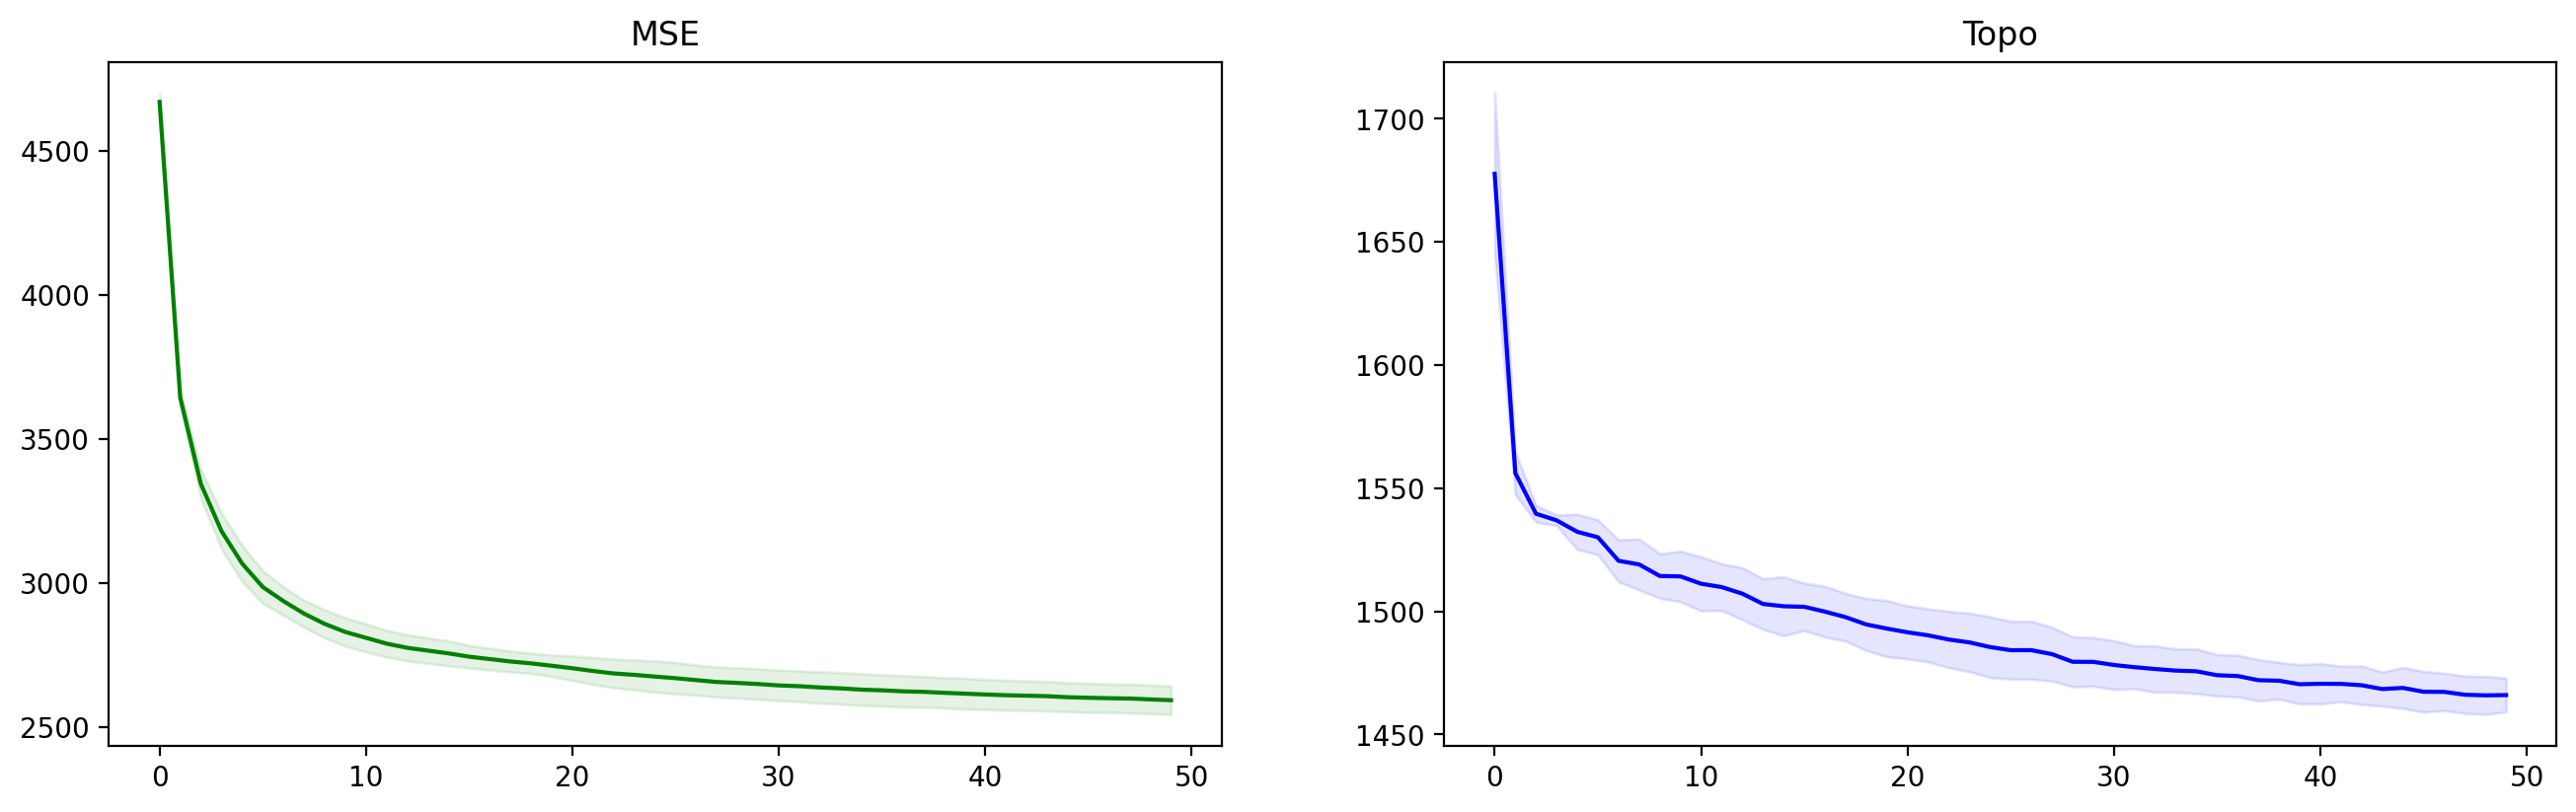

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
ax[0].set_title("MSE")
ax[1].set_title("Topo")
ax[0].plot(history.mean(axis=0)[:, 0], c="g", label="MSE")
ax[0].fill_between(x, mse_ci1, mse_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:, 1], c="b", label="Topo")
ax[1].fill_between(x, topo_ci1, topo_ci2, color="b", alpha=0.1)
plt.show()

In [33]:
def plot_dgm(img, ax):
    cmplx = gd.CubicalComplex(dimensions=img.shape, top_dimensional_cells=img.flatten())
    diag = cmplx.persistence()
    gd.plot_persistence_diagram(diag, legend=True, axes=ax)

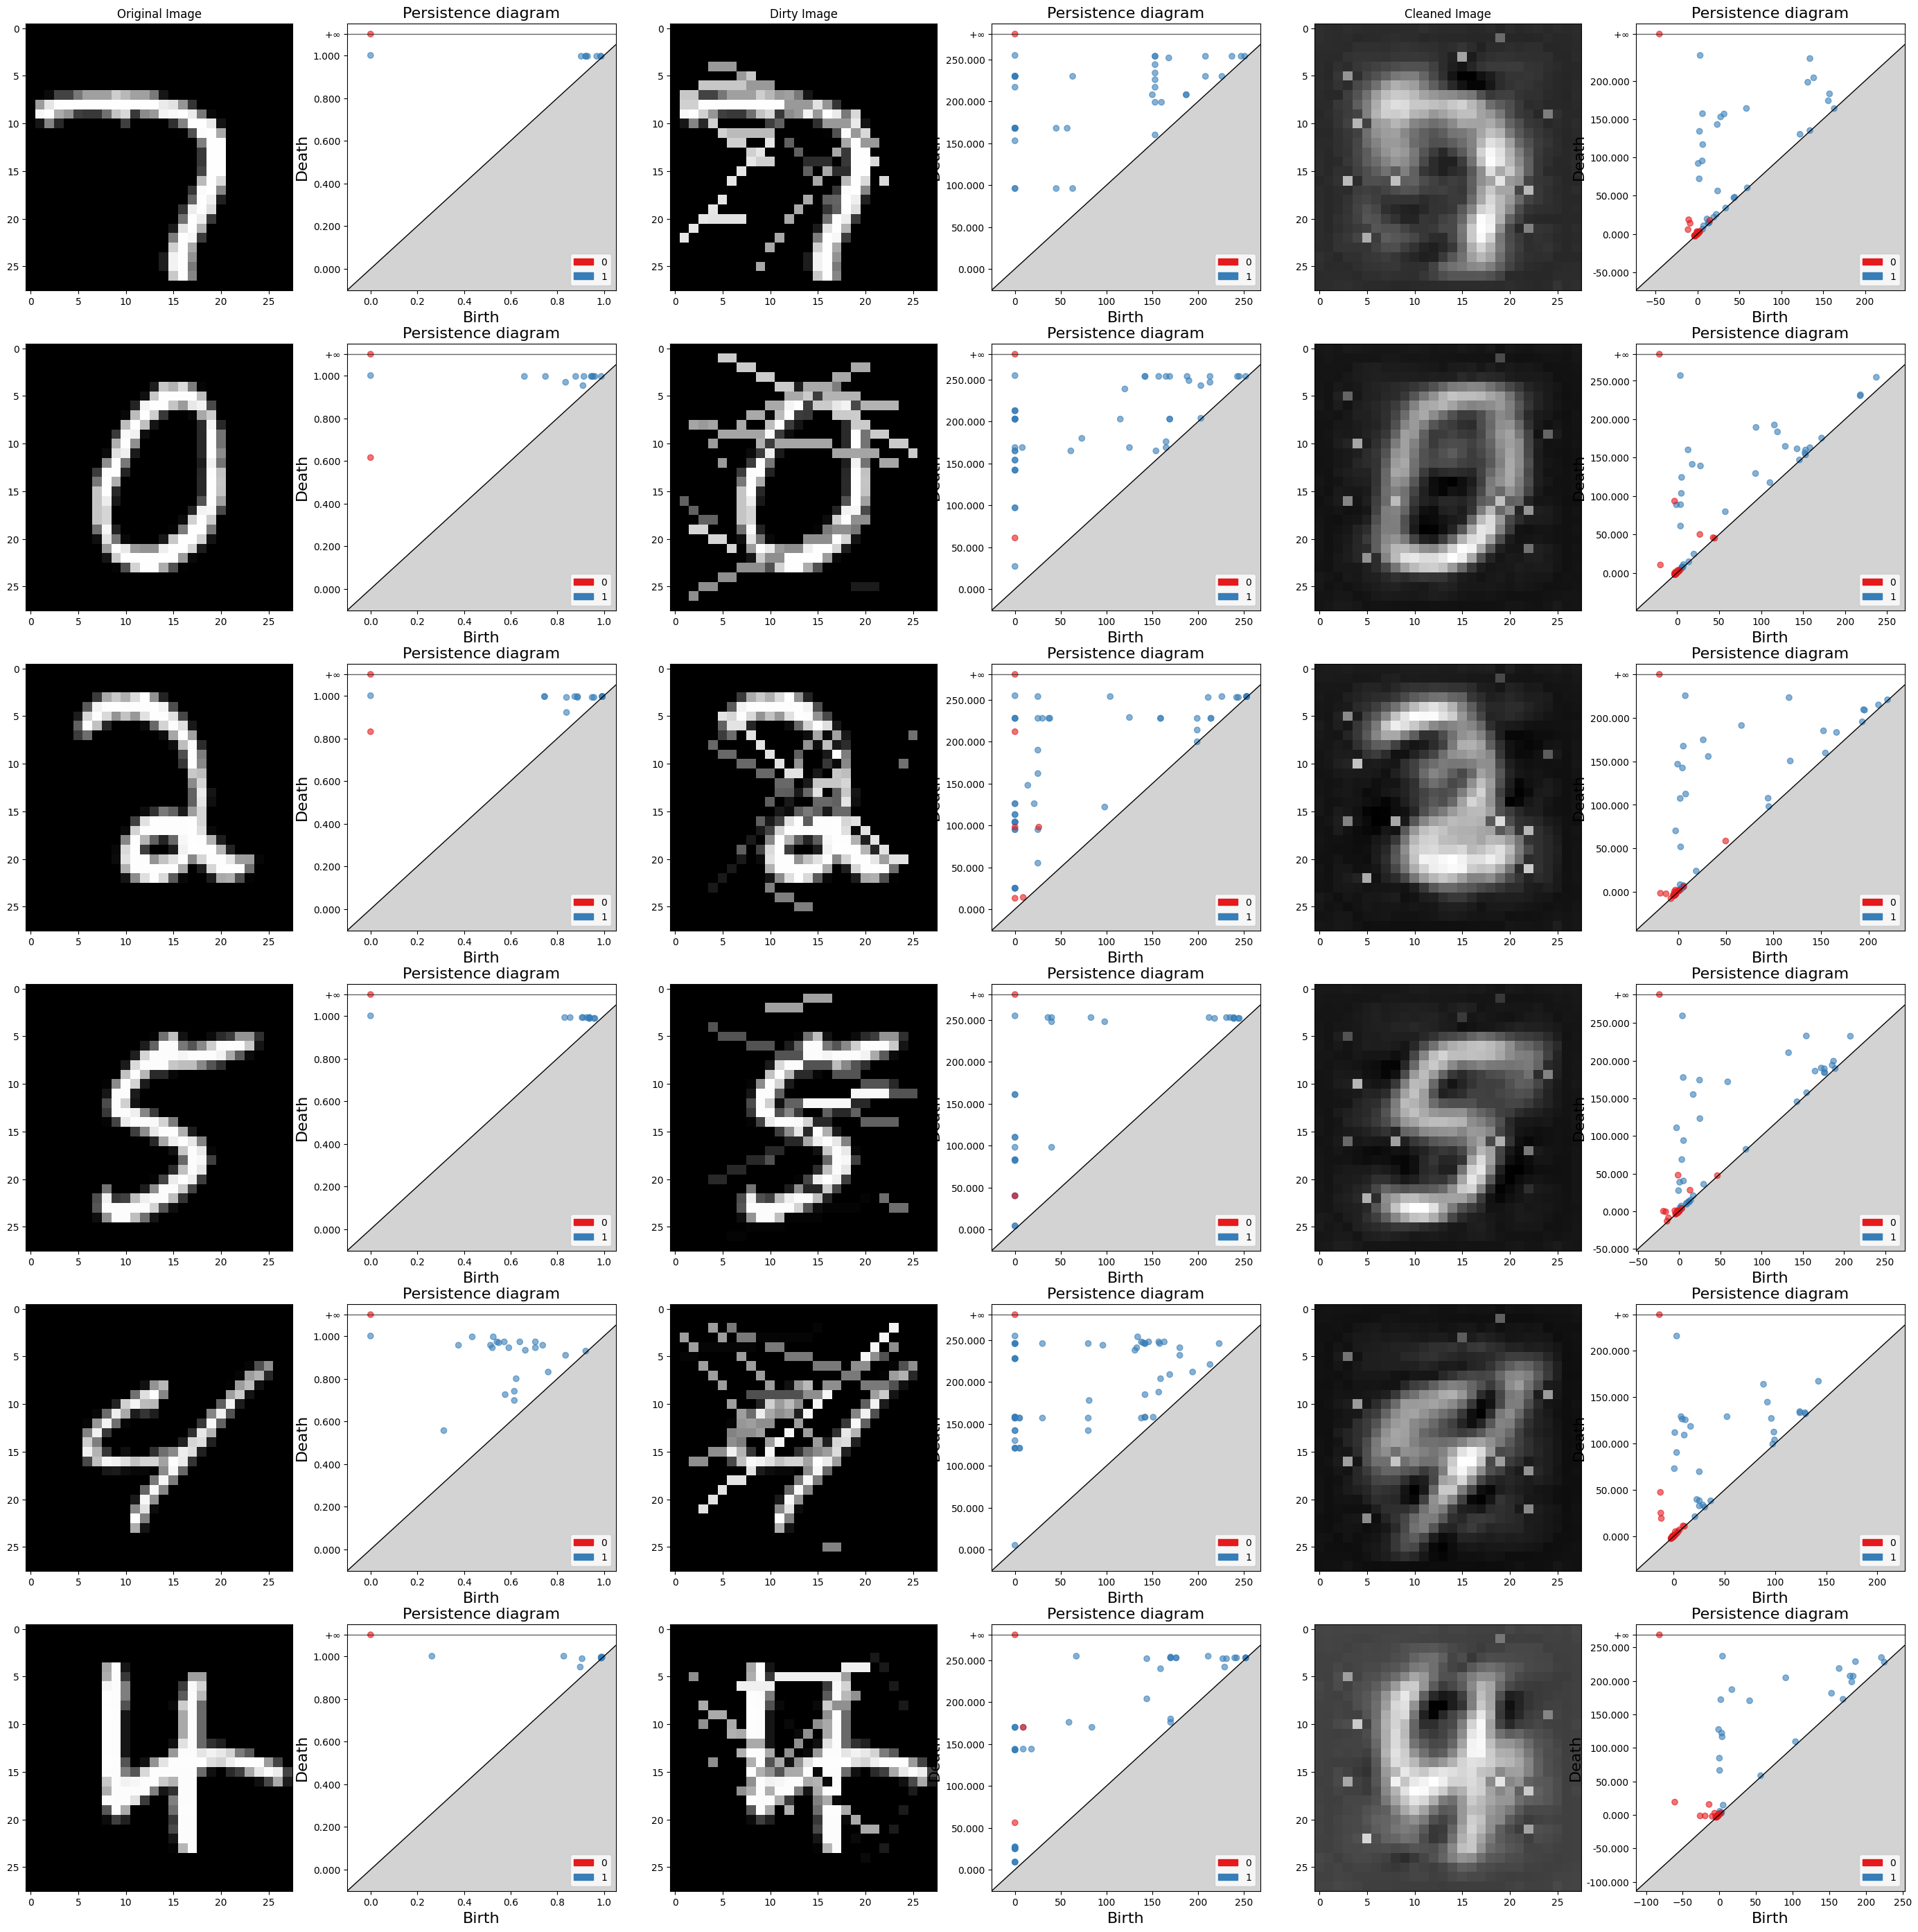

In [34]:
# Результаты работы модели на 6-и случайных примерах

f, axes = plt.subplots(6, 6, figsize=(35, 35))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Original diagram")
axes[0, 2].set_title("Dirty Image")
axes[0, 3].set_title("Dirty diagram")
axes[0, 4].set_title("Cleaned Image")
axes[0, 5].set_title("Cleaned diagram")

test_imgs = np.random.randint(0, 500, size=6)
for idx in range((6)):
    dirty = testset[test_imgs[idx]][0]
    clean = testset[test_imgs[idx]][1]
    label = testset[test_imgs[idx]][2]
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)

    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()

    dirty = dirty.view(1, 28, 28)
    dirty = dirty.permute(1, 2, 0).squeeze(2)
    dirty = dirty.detach().cpu().numpy()

    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()

    axes[idx, 0].imshow(clean, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][1], axes[idx, 1])

    axes[idx, 2].imshow(dirty, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][0], axes[idx, 3])
    axes[idx, 4].imshow(output, cmap="gray")
    plot_dgm(output, axes[idx, 5])

In [35]:
# Выводим историю loss'ов (на всякий случай)
print(history)

[[[4639.140625   1711.11621094]
  [3676.17895508 1549.54248047]
  [3372.40380859 1535.7512207 ]
  [3226.50756836 1533.99865723]
  [3122.21728516 1522.29394531]
  [3033.92919922 1520.10009766]
  [2977.30126953 1514.13818359]
  [2938.46728516 1511.30285645]
  [2909.09936523 1506.56408691]
  [2883.07397461 1505.45422363]
  [2861.38525391 1500.73339844]
  [2838.37231445 1500.8067627 ]
  [2823.31542969 1495.64990234]
  [2810.18359375 1491.73608398]
  [2799.45483398 1489.00244141]
  [2779.26928711 1492.34545898]
  [2769.11621094 1489.3605957 ]
  [2758.75634766 1487.89489746]
  [2752.13696289 1484.03344727]
  [2746.95092773 1481.19519043]
  [2741.84350586 1478.47607422]
  [2735.81201172 1477.8013916 ]
  [2730.04248047 1475.07714844]
  [2728.51586914 1473.46789551]
  [2723.34008789 1469.92041016]
  [2716.89526367 1470.12561035]
  [2705.00170898 1471.49902344]
  [2696.37817383 1470.32617188]
  [2690.79345703 1467.45092773]
  [2686.40795898 1467.8347168 ]
  [2681.63696289 1466.52844238]
  [2677.